# HydroSOS Streamflow Status Product Methodology
#### Jose Valles (jose.valles.leon@gmail.com)

## One month status product

### Importing the data and finding missing dates

In [1]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

In [2]:
class EstadoHidrologico:
    def __init__(self, station_name,values,flow_cat):
        self.station_name = station_name
        self.values = values
        self.flow_cat = flow_cat
        self.DISCHARGE_MONTHLY = None

    def cargar_datos(self):
        self.DISCHARGE_MONTHLY = pd.read_csv(f'../waterbalance/input/{self.station_name}.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
        self.DISCHARGE_MONTHLY['year'] = self.DISCHARGE_MONTHLY.index.year
        self.DISCHARGE_MONTHLY['month'] = self.DISCHARGE_MONTHLY.index.month
        self.DISCHARGE_MONTHLY['water_year'] = self.DISCHARGE_MONTHLY.index.year.where(self.DISCHARGE_MONTHLY.index.month < 4, self.DISCHARGE_MONTHLY.index.year + 1)
        self.DISCHARGE_MONTHLY.index = self.DISCHARGE_MONTHLY.index.map(lambda t: t.replace(day=1))
        return self.DISCHARGE_MONTHLY

    def estado_mensual(self):
        # Climatologia
        DISCHARGE_SELECTION = self.DISCHARGE_MONTHLY[(self.DISCHARGE_MONTHLY['year'] >= 1981) & (self.DISCHARGE_MONTHLY['year'] <= 2010)]
        DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
        DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['Caudal'])
        # Calcular indicadores
        self.DISCHARGE_MONTHLY['average_percentage'] = np.nan
        self.DISCHARGE_MONTHLY['rank_average'] = np.nan
        self.DISCHARGE_MONTHLY['non_missing'] = np.nan

        for i in range(len(self.DISCHARGE_MONTHLY)):
            # Extract the current month 
            m = self.DISCHARGE_MONTHLY.month[i]
            # Extract the current year
            y = self.DISCHARGE_MONTHLY.year[i]
            self.DISCHARGE_MONTHLY.loc[self.DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'rank_average']  = self.DISCHARGE_MONTHLY.query('month==@m')['Caudal'].rank()
            self.DISCHARGE_MONTHLY.loc[self.DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'non_missing']  = self.DISCHARGE_MONTHLY.query('month==@m')["Caudal"].notnull().sum()
            self.DISCHARGE_MONTHLY.loc[self.DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'average_percentage'] = (self.DISCHARGE_MONTHLY['Caudal'][i] - DISCHARGE_AVERAGE.query('month == @m')["Caudal"].item()) / DISCHARGE_AVERAGE.query('month == @m')["Caudal"].item()

        self.DISCHARGE_MONTHLY['percentile'] = self.DISCHARGE_MONTHLY['rank_average']/(self.DISCHARGE_MONTHLY['non_missing']+1)

        criteria = [self.DISCHARGE_MONTHLY['percentile'].between(0.90,1.00),
            self.DISCHARGE_MONTHLY['percentile'].between(0.75,0.90),
            self.DISCHARGE_MONTHLY['percentile'].between(0.25,0.75),
            self.DISCHARGE_MONTHLY['percentile'].between(0.10,0.25),
            self.DISCHARGE_MONTHLY['percentile'].between(0.00,0.10)]

        self.DISCHARGE_MONTHLY['percentile_range'] = np.select(criteria,self.values,None)
        self.DISCHARGE_MONTHLY['flowcat'] = np.select(criteria,self.flow_cat,pd.NA)

        return self.DISCHARGE_MONTHLY
    
    def estado_trimestral(self):
        # Agregar caudales
        DISCHARGE_THREE_MONTHS = pd.DataFrame(self.DISCHARGE_MONTHLY['Caudal'].rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < 0.5 else np.nan))
        # Agregar columnas
        DISCHARGE_THREE_MONTHS['startMonth'] = (DISCHARGE_THREE_MONTHS.index - pd.DateOffset(months=2)).month
        DISCHARGE_THREE_MONTHS['endMonth'] = DISCHARGE_THREE_MONTHS.index.month
        DISCHARGE_THREE_MONTHS['year'] = DISCHARGE_THREE_MONTHS.index.year
        DISCHARGE_THREE_MONTHS.index = DISCHARGE_THREE_MONTHS.index.map(lambda t: t.replace(day=1))
        # Climatologia
        DISCHARGE_SELECTION_THREE_MONTH = DISCHARGE_THREE_MONTHS[(DISCHARGE_THREE_MONTHS['year'] >= 1981) & (DISCHARGE_THREE_MONTHS['year'] < 2010)]
        DISCHARGE_AVERAGE_THREE_MONTH = DISCHARGE_SELECTION_THREE_MONTH.groupby(DISCHARGE_SELECTION_THREE_MONTH.startMonth).mean()
        DISCHARGE_AVERAGE_THREE_MONTH = DISCHARGE_AVERAGE_THREE_MONTH.reindex(columns=['Caudal'])
        # Calcular indicadores
        DISCHARGE_THREE_MONTHS['average_percentage'] = np.nan
        DISCHARGE_THREE_MONTHS['rank_average'] = np.nan
        DISCHARGE_THREE_MONTHS['non_missing'] = np.nan

        for i in range(len(DISCHARGE_THREE_MONTHS)):
            # Extract the current month 
            m = DISCHARGE_THREE_MONTHS.startMonth[i]
            # Extract the current year
            y = DISCHARGE_THREE_MONTHS.year[i]
            DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'rank_average']  = DISCHARGE_THREE_MONTHS.query('startMonth==@m')['Caudal'].rank()
            DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'non_missing']  = DISCHARGE_THREE_MONTHS.query('startMonth==@m')["Caudal"].notnull().sum()
            DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'average_percentage'] = (DISCHARGE_THREE_MONTHS['Caudal'][i] - DISCHARGE_AVERAGE_THREE_MONTH.query('startMonth == @m')["Caudal"].item()) / DISCHARGE_AVERAGE_THREE_MONTH.query('startMonth == @m')["Caudal"].item()

        DISCHARGE_THREE_MONTHS['percentile'] = DISCHARGE_THREE_MONTHS['rank_average']/(DISCHARGE_THREE_MONTHS['non_missing']+1)

        criteria_three_months = [DISCHARGE_THREE_MONTHS['percentile'].between(0.90,1.00),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.75,0.90),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.25,0.75),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.10,0.25),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.00,0.10)]

        DISCHARGE_THREE_MONTHS['percentile_range'] = np.select(criteria_three_months,self.values,None)
        DISCHARGE_THREE_MONTHS['flowcat'] = np.select(criteria_three_months,self.flow_cat,pd.NA)

        row_labels = {1:'JFM',
             2:'FMA',
             3:'MAM',
             4:'AMJ',
             5:'MJJ',
             6:'JJA',
             7:'JAS',
             8:'ASO',
             9:'SON',
             10:'OND',
             11:'NDE',
             12:'DEF'}
        
        DISCHARGE_THREE_MONTHS['period'] = DISCHARGE_THREE_MONTHS['startMonth'].replace(row_labels) 
        return DISCHARGE_THREE_MONTHS
    
    def estado_anual(self):
        # Agrgar caudales
        DISCHARGE_TWELVE_MONTHS = pd.DataFrame(self.DISCHARGE_MONTHLY['Caudal'].rolling(12).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < 0.5 else np.nan))
        DISCHARGE_TWELVE_MONTHS['startMonth'] = (DISCHARGE_TWELVE_MONTHS.index - pd.DateOffset(months=2)).month
        DISCHARGE_TWELVE_MONTHS['endMonth'] = DISCHARGE_TWELVE_MONTHS.index.month
        DISCHARGE_TWELVE_MONTHS['year'] = DISCHARGE_TWELVE_MONTHS.index.year
        DISCHARGE_TWELVE_MONTHS.index = DISCHARGE_TWELVE_MONTHS.index.map(lambda t: t.replace(day=1))
        # Climatologia
        DISCHARGE_SELECTION_TWELVE_MONTH = DISCHARGE_TWELVE_MONTHS[(DISCHARGE_TWELVE_MONTHS['year'] >= 1981) & (DISCHARGE_TWELVE_MONTHS['year'] < 2010)]
        DISCHARGE_AVERAGE_TWELVE_MONTH = DISCHARGE_SELECTION_TWELVE_MONTH.groupby(DISCHARGE_SELECTION_TWELVE_MONTH.startMonth).mean()
        DISCHARGE_AVERAGE_TWELVE_MONTH = DISCHARGE_AVERAGE_TWELVE_MONTH.reindex(columns=['Caudal'])
        # Calcular indice
        DISCHARGE_TWELVE_MONTHS['average_percentage'] = np.nan
        DISCHARGE_TWELVE_MONTHS['rank_average'] = np.nan
        DISCHARGE_TWELVE_MONTHS['non_missing'] = np.nan

        for i in range(len(DISCHARGE_TWELVE_MONTHS)):
            # Extract the current month 
            m = DISCHARGE_TWELVE_MONTHS.startMonth[i]
            # Extract the current year
            y = DISCHARGE_TWELVE_MONTHS.year[i]
            DISCHARGE_TWELVE_MONTHS.loc[DISCHARGE_TWELVE_MONTHS.eval('startMonth==@m & year==@y'),'rank_average']  = DISCHARGE_TWELVE_MONTHS.query('startMonth==@m')['Caudal'].rank()
            DISCHARGE_TWELVE_MONTHS.loc[DISCHARGE_TWELVE_MONTHS.eval('startMonth==@m & year==@y'),'non_missing']  = DISCHARGE_TWELVE_MONTHS.query('startMonth==@m')["Caudal"].notnull().sum()
            DISCHARGE_TWELVE_MONTHS.loc[DISCHARGE_TWELVE_MONTHS.eval('startMonth==@m & year==@y'),'average_percentage'] = (DISCHARGE_TWELVE_MONTHS['Caudal'][i] - DISCHARGE_AVERAGE_TWELVE_MONTH.query('startMonth == @m')["Caudal"].item()) / DISCHARGE_AVERAGE_TWELVE_MONTH.query('startMonth == @m')["Caudal"].item()
    
        DISCHARGE_TWELVE_MONTHS['percentile'] = DISCHARGE_TWELVE_MONTHS['rank_average']/(DISCHARGE_TWELVE_MONTHS['non_missing']+1)

        criteria_twelve_months = [DISCHARGE_TWELVE_MONTHS['percentile'].between(0.90,1.00),
            DISCHARGE_TWELVE_MONTHS['percentile'].between(0.75,0.90),
            DISCHARGE_TWELVE_MONTHS['percentile'].between(0.25,0.75),
            DISCHARGE_TWELVE_MONTHS['percentile'].between(0.10,0.25),
            DISCHARGE_TWELVE_MONTHS['percentile'].between(0.00,0.10)]

        DISCHARGE_TWELVE_MONTHS['percentile_range'] = np.select(criteria_twelve_months,self.values,None)
        DISCHARGE_TWELVE_MONTHS['flowcat'] = np.select(criteria_twelve_months,self.flow_cat,pd.NA)
        return DISCHARGE_TWELVE_MONTHS




In [3]:
station_name = '41'
values = ['High flow','Above normal','Normal range','Below normal','Low flow']
flow_cat = [5,4,3,2,1]

In [4]:
hydro_status = EstadoHidrologico(station_name = station_name,values=values,flow_cat=flow_cat)

In [5]:
DISCHARGE_MONTHLY = hydro_status.cargar_datos()
HTML(DISCHARGE_MONTHLY.tail(12).to_html())

,Caudal,year,month,water_year
Fecha,,,,
2024-12-01,18.841550,2024,12,2025
2025-01-01,8.905551,2025,1,2025
2025-02-01,7.548901,2025,2,2025
2025-03-01,3.812155,2025,3,2025
2025-04-01,13.764473,2025,4,2026
2025-05-01,59.658248,2025,5,2026
2025-06-01,43.138465,2025,6,2026
2025-07-01,70.909870,2025,7,2026
2025-08-01,75.057714,2025,8,2026


In [6]:
STATUS_ONE_MONTH = hydro_status.estado_mensual()
HTML(STATUS_ONE_MONTH.tail(12).to_html())

,Caudal,year,month,water_year,average_percentage,rank_average,non_missing,percentile,percentile_range,flowcat
Fecha,,,,,,,,,,
2024-12-01,18.841550,2024,12,2025,-0.508608,23.0,45.0,0.500000,Normal range,3
2025-01-01,8.905551,2025,1,2025,-0.649185,18.0,46.0,0.382979,Normal range,3
2025-02-01,7.548901,2025,2,2025,-0.866330,13.0,46.0,0.276596,Normal range,3
2025-03-01,3.812155,2025,3,2025,-0.902188,10.0,46.0,0.212766,Below normal,2
2025-04-01,13.764473,2025,4,2026,-0.792875,18.0,46.0,0.382979,Normal range,3
2025-05-01,59.658248,2025,5,2026,-0.368818,25.0,46.0,0.531915,Normal range,3
2025-06-01,43.138465,2025,6,2026,-0.619304,14.0,46.0,0.297872,Normal range,3
2025-07-01,70.909870,2025,7,2026,-0.502578,17.0,46.0,0.361702,Normal range,3
2025-08-01,75.057714,2025,8,2026,-0.296980,15.0,46.0,0.319149,Normal range,3


In [7]:
STATUS_THREE_MONTH = hydro_status.estado_trimestral()
HTML(STATUS_THREE_MONTH.tail(12).to_html())

,Caudal,startMonth,endMonth,year,average_percentage,rank_average,non_missing,percentile,percentile_range,flowcat,period
Fecha,,,,,,,,,,,
2024-12-01,47.962740,10,12,2024,-0.272966,22.0,45.0,0.478261,Normal range,3,OND
2025-01-01,23.486411,11,1,2025,-0.464331,21.0,45.0,0.456522,Normal range,3,NDE
2025-02-01,11.765334,12,2,2025,-0.677152,12.0,45.0,0.260870,Normal range,3,DEF
2025-03-01,6.755536,1,3,2025,-0.814165,11.0,46.0,0.234043,Below normal,2,JFM
2025-04-01,8.375176,2,4,2025,-0.834659,8.0,46.0,0.170213,Below normal,2,FMA
2025-05-01,25.744959,3,5,2025,-0.621669,19.0,46.0,0.404255,Normal range,3,MAM
2025-06-01,38.853729,4,6,2025,-0.587666,17.0,46.0,0.361702,Normal range,3,AMJ
2025-07-01,57.902195,5,7,2025,-0.510996,12.0,46.0,0.255319,Normal range,3,MJJ
2025-08-01,63.035350,6,8,2025,-0.481982,8.0,46.0,0.170213,Below normal,2,JJA


In [8]:
STATUS_TWELVE_MONTH = hydro_status.estado_anual()
HTML(STATUS_TWELVE_MONTH.tail(12).to_html())

,Caudal,startMonth,endMonth,year,average_percentage,rank_average,non_missing,percentile,percentile_range,flowcat
Fecha,,,,,,,,,,
2024-12-01,135.927979,10,12,2024,0.725320,43.0,45.0,0.934783,High flow,5
2025-01-01,133.665028,11,1,2025,0.666163,43.0,45.0,0.934783,High flow,5
2025-02-01,133.090384,12,2,2025,0.659683,43.0,45.0,0.934783,High flow,5
2025-03-01,127.706646,1,3,2025,0.595359,42.0,45.0,0.913043,High flow,5
2025-04-01,113.529745,2,4,2025,0.428037,40.0,45.0,0.869565,Above normal,4
2025-05-01,70.359668,3,5,2025,-0.112612,18.0,45.0,0.391304,Normal range,3
2025-06-01,58.225595,4,6,2025,-0.259028,12.0,45.0,0.260870,Normal range,3
2025-07-01,59.447617,5,7,2025,-0.241039,15.0,45.0,0.326087,Normal range,3
2025-08-01,55.598162,6,8,2025,-0.288347,12.0,45.0,0.260870,Normal range,3


In [9]:
STATUS_ONE_MONTH = STATUS_ONE_MONTH.rename_axis('date')
STATUS_THREE_MONTH = STATUS_THREE_MONTH.rename_axis('date')
STATUS_TWELVE_MONTH = STATUS_TWELVE_MONTH.rename_axis('date')

## Export to CSV files - DINAGUA format

In [10]:
# DISCHARGE_MONTHLY[['discharge','month','year','average_percentage','percentile','percentile_range']].to_csv(f'../output/{station_name}_one-month.csv',float_format='%.3f')

In [11]:
# DISCHARGE_THREE_MONTHS[['discharge','startMonth','endMonth','year','average_percentage','percentile','percentile_range']].to_csv(f'../output/{station_name}_three-month.csv',float_format='%.3f')

## Export to CSV files - Demostrator format

In [12]:
# STATUS_ONE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/01_month/cat_{station_name}.csv',na_rep='NA')
# STATUS_THREE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/03_month/cat_{station_name}.csv',na_rep='NA')
# STATUS_TWELVE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/12_month/cat_{station_name}.csv',na_rep='NA')

## Run all the basin 

In [13]:
# Definir la fecha de finalización para el HeatMap
fecha_fin = "2025-11-01"
back_months = 18

# Generar la secuencia de fechas de los X meses anteriores, incluyendo el mes de la fecha de finalización
fechas = pd.date_range(end=fecha_fin, periods=back_months, freq='MS')
# Crear un DataFrame vacío con las fechas como índice
df_cat = pd.DataFrame(index=fechas)
df_cat.index.name = 'FECHA'

# Importar nombre de subcuencas
ALL_BASIN = pd.read_csv(f'../waterbalance/cuenca_nivel2.csv',index_col="Codigo")
allbasins_n2 = pd.read_csv(f'../waterbalance/cuencas_nombres.csv')

In [14]:
values = ['High flow','Above normal','Normal range','Below normal','Low flow']
flow_cat = [5,4,3,2,1]
for columna, datos in ALL_BASIN.iteritems():
    # print(columna)
    # Create model instance 
    hydro_status = EstadoHidrologico(station_name = columna,values=values,flow_cat=flow_cat)
    DISCHARGE_MONTHLY = hydro_status.cargar_datos()
    STATUS_ONE_MONTH = hydro_status.estado_mensual()
    # STATUS_THREE_MONTH = hydro_status.estado_trimestral()
    # STATUS_TWELVE_MONTH = hydro_status.estado_anual()
    STATUS_ONE_MONTH = STATUS_ONE_MONTH.rename_axis('date')
    # STATUS_THREE_MONTH = STATUS_THREE_MONTH.rename_axis('date')
    # STATUS_TWELVE_MONTH = STATUS_TWELVE_MONTH.rename_axis('date')
    # Extract categories from the last back_months variable
    df_cat[columna] = STATUS_ONE_MONTH.loc[fechas]['flowcat']
    # Exportar csv
    # STATUS_ONE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/01_month/cat_{columna}.csv',na_rep='NA')
    # STATUS_THREE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/03_month/cat_{columna}.csv',na_rep='NA')
    # STATUS_TWELVE_MONTH[['flowcat']].to_csv(f'../waterbalance/output_csv/12_month/cat_{columna}.csv',na_rep='NA')
    

In [15]:
# Housecleaning 
df_cat_float = df_cat.astype(float)
df_cat_float = df_cat_float.reset_index()
piv = pd.pivot_table(df_cat_float,columns=["FECHA"])

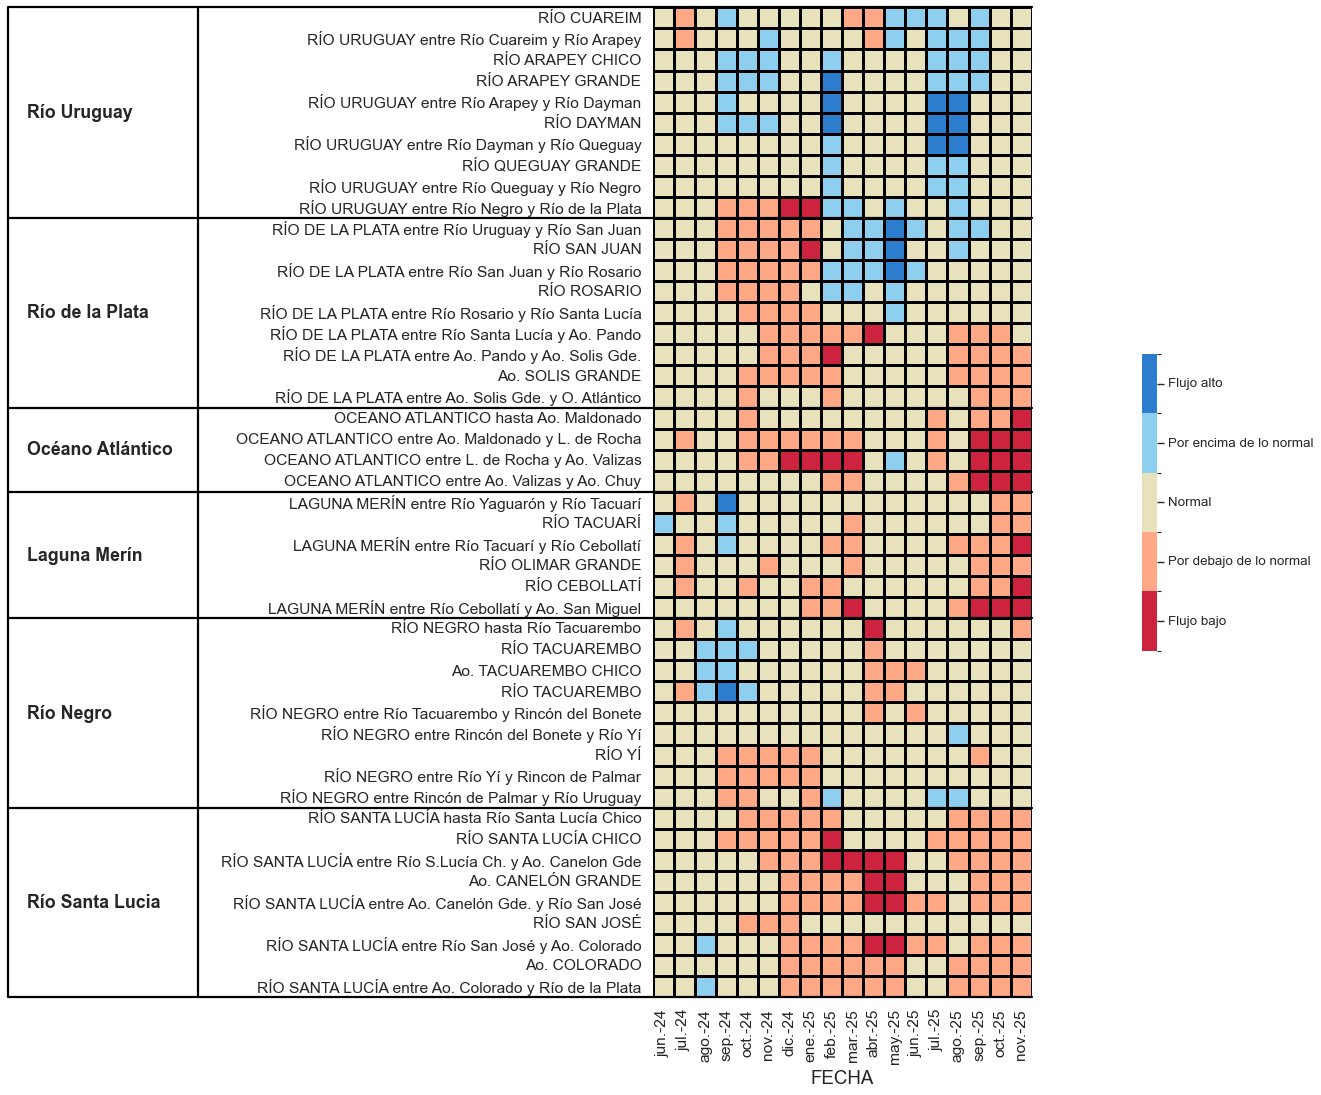

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm 
import locale
import numpy as np

locale.setlocale(locale.LC_TIME, "es_ES")

# Definir colores discretos para cada categoría
colors = ['#CD233F', '#FFA885', '#E7E2BC', '#8ECEEE', '#2C7DCD']
cmap = ListedColormap(colors)

bounds = [1, 2, 3, 4, 5, 6]
my_norm = BoundaryNorm(bounds, ncolors=len(colors))

font_size = 12
factor_delta = 2
ancho_linea = 2

# 1. Define the mapping for the groups
group_map = {
    '1': 'Río Uruguay',
    '2': 'Río de la Plata',
    '3': 'Océano Atlántico',
    '4': 'Laguna Merín',
    '5': 'Río Negro',
    '6': 'Río Santa Lucia'
}
# 2. Get the group for each row in the pivot table (assuming piv index is Codigo)
# We take the first character of the basin code string
basin_groups = [group_map.get(str(code)[0], "Otro") for code in piv.index]

# Identify where a new group starts to place labels and lines

change_indices = np.where(np.array(basin_groups)[:-1] != np.array(basin_groups)[1:])[0]

# --- INICIO DEL PLOT MODIFICADO ---
fig, ax = plt.subplots(figsize=(28, 14))

# Ajuste importante: aumentar el margen izquierdo para que quepan las etiquetas y los bordes
plt.subplots_adjust(left=0.3) 

sns.heatmap(piv, square=True, cmap=cmap, norm=my_norm, linewidths=1, 
            linecolor='black', ax=ax, cbar_kws={'shrink': 0.3})

# 3. Agregar Etiquetas de Grupo y Bordes Extendidos
last_idx = 0
# Definimos qué tan a la izquierda queremos que empiece el borde (en fracción del eje)
# -0.6 suele ser suficiente para cubrir el nombre del grupo y la subcuenca
x_lim_left = -1.7

for idx in list(change_indices) + [len(basin_groups) - 1]:
    mid_point = (last_idx + idx + 1) / 2
    group_name = basin_groups[last_idx]
    
    # Texto del Grupo (posicionado más a la izquierda que las etiquetas de los ríos)
    ax.annotate(group_name, xy=(x_lim_left + 0.05, mid_point), 
                xycoords=('axes fraction', 'data'),
                ha='left', va='center', fontweight='bold', fontsize=16)
    
    # Línea horizontal divisoria que se extiende a la izquierda
    # xmin=-0.6 significa que empieza un 60% del ancho del plot hacia la izquierda
    ax.axhline(y=idx + 1, xmin=x_lim_left, xmax=1.0, 
               color='black', linewidth=ancho_linea, clip_on=False)
    
    # Línea horizontal superior para el primer grupo (opcional para cerrar el cuadro arriba)
    if last_idx == 0:
        ax.axhline(y=0, xmin=x_lim_left, xmax=1.0, 
                   color='black', linewidth=ancho_linea, clip_on=False)
        
    last_idx = idx + 1

# 4. Agregar Línea Vertical en el extremo izquierdo para cerrar el borde
ax.vlines(x=x_lim_left, ymin=0, ymax=len(piv), transform=ax.get_yaxis_transform(),
          color='black', linewidth=ancho_linea, clip_on=False)

# 5. Agregar Línea Vertical divisoria entre Grupo y Subcuenca (opcional)
ax.vlines(x=x_lim_left + 0.5, ymin=0, ymax=len(piv), transform=ax.get_yaxis_transform(),
          color='black', linewidth=ancho_linea, clip_on=False)

# Formateo de etiquetas existentes
ax.set_yticklabels(allbasins_n2.nombre, rotation=0, fontsize=font_size+factor_delta)
ax.set_xticklabels(df_cat_float['FECHA'].dt.strftime('%b-%y'), fontsize=font_size+factor_delta)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([(b0+b1)/2 for b0, b1 in zip(bounds[:-1], bounds[1:])])
colorbar.set_ticklabels(['Flujo bajo', 'Por debajo de lo normal', 'Normal', 'Por encima de lo normal', 'Flujo alto'])

colorbar.ax.tick_params(labelsize=font_size)
colorbar.ax.yaxis.set_tick_params(rotation=0)
colorbar.ax.yaxis.set_label_position('left')
ax.figure.axes[-1].yaxis.label.set_size(font_size)

plt.rcParams.update({'font.family':'Arial'})
sns.set(font_scale=1.4)
plt.tight_layout()

### Plot the HeatMap

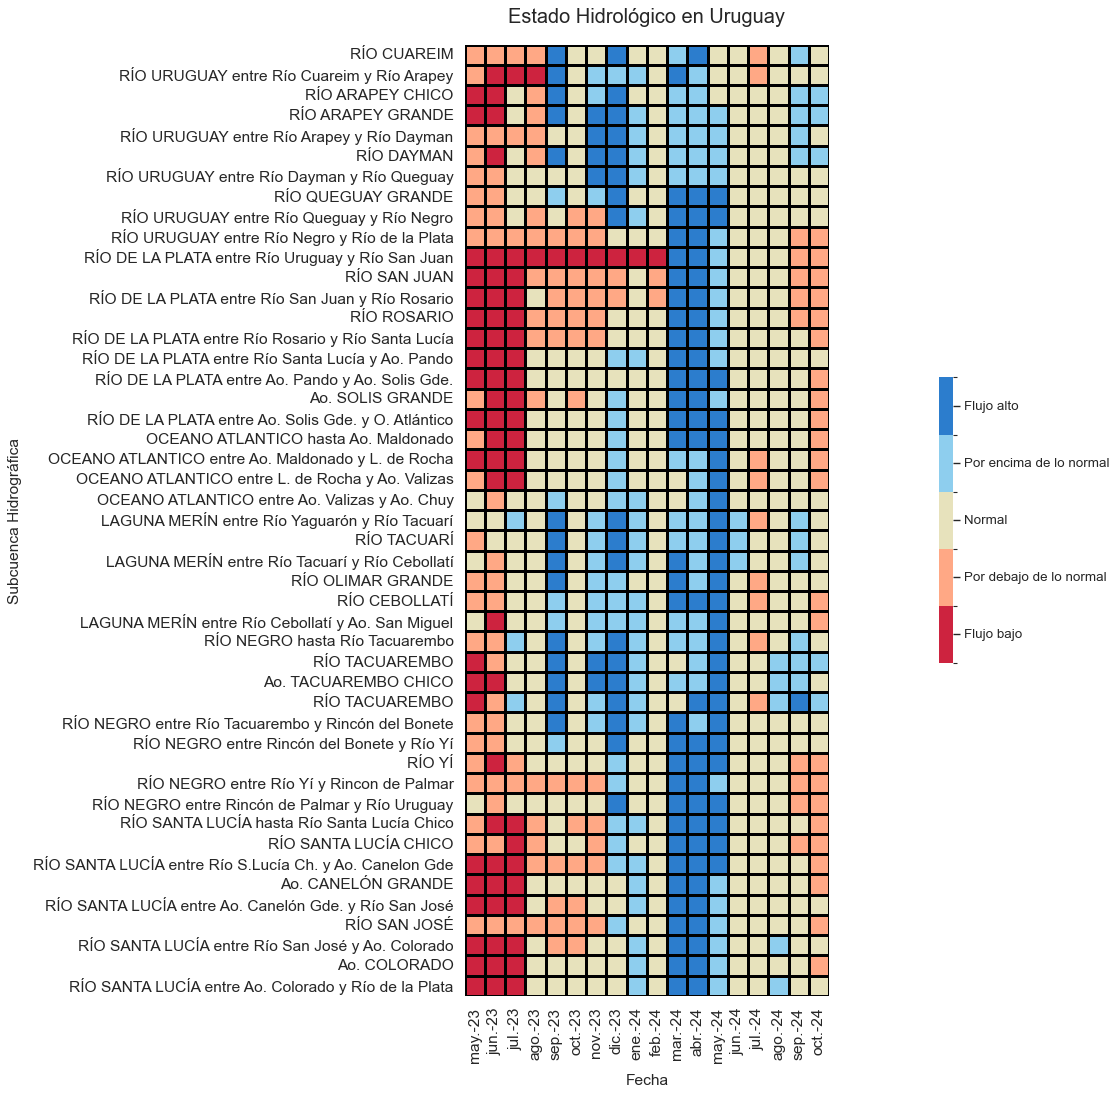

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm 
import locale

locale.setlocale(locale.LC_TIME, "es_ES")



# Definir colores discretos para cada categoría
colors = ['#CD233F', '#FFA885', '#E7E2BC', '#8ECEEE', '#2C7DCD']
cmap = ListedColormap(colors)

bounds = [1, 2, 3, 4, 5, 6]
my_norm = BoundaryNorm(bounds, ncolors=len(colors))

font_size = 12
factor_delta = 2

# Crear el heatmap
fig, ax = plt.subplots(figsize=(28,14))
ax = sns.heatmap(piv, 
                 square=True, 
                 cmap=cmap, 
                 vmin=1, 
                 vmax=5,
                 annot = False,
                 norm=my_norm,
                 linewidths=1,
                 linecolor='black', 
                 ax=ax, 
                 annot_kws={'fontsize': font_size, 'fontweight':'bold',},
                 cbar_kws={'label': '','orientation':'vertical','shrink': 0.3})

ax.set_title('Estado Hidrológico en Uruguay', pad=20, loc='center',size=18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_xlabel('Fecha',rotation=0, labelpad=10,size=font_size+factor_delta)
ax.set_xticklabels(df_cat_float['FECHA'].dt.strftime('%b-%y'),fontsize=font_size+factor_delta)

ax.set_ylabel('Subcuenca Hidrográfica', rotation=90, labelpad=10, fontsize=font_size+factor_delta)
ax.tick_params(axis='y', labelsize=font_size+factor_delta)

ax.set_yticklabels(allbasins_n2.nombre,rotation=0)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([(b0+b1)/2 for b0, b1 in zip(bounds[:-1], bounds[1:])])
colorbar.set_ticklabels(['Flujo bajo', 'Por debajo de lo normal', 'Normal', 'Por encima de lo normal', 'Flujo alto'])

colorbar.ax.tick_params(labelsize=font_size)
colorbar.ax.yaxis.set_tick_params(rotation=0)
colorbar.ax.yaxis.set_label_position('left')
ax.figure.axes[-1].yaxis.label.set_size(font_size)

plt.rcParams.update({'font.family':'Arial'})
sns.set(font_scale=1.4)
plt.tight_layout()

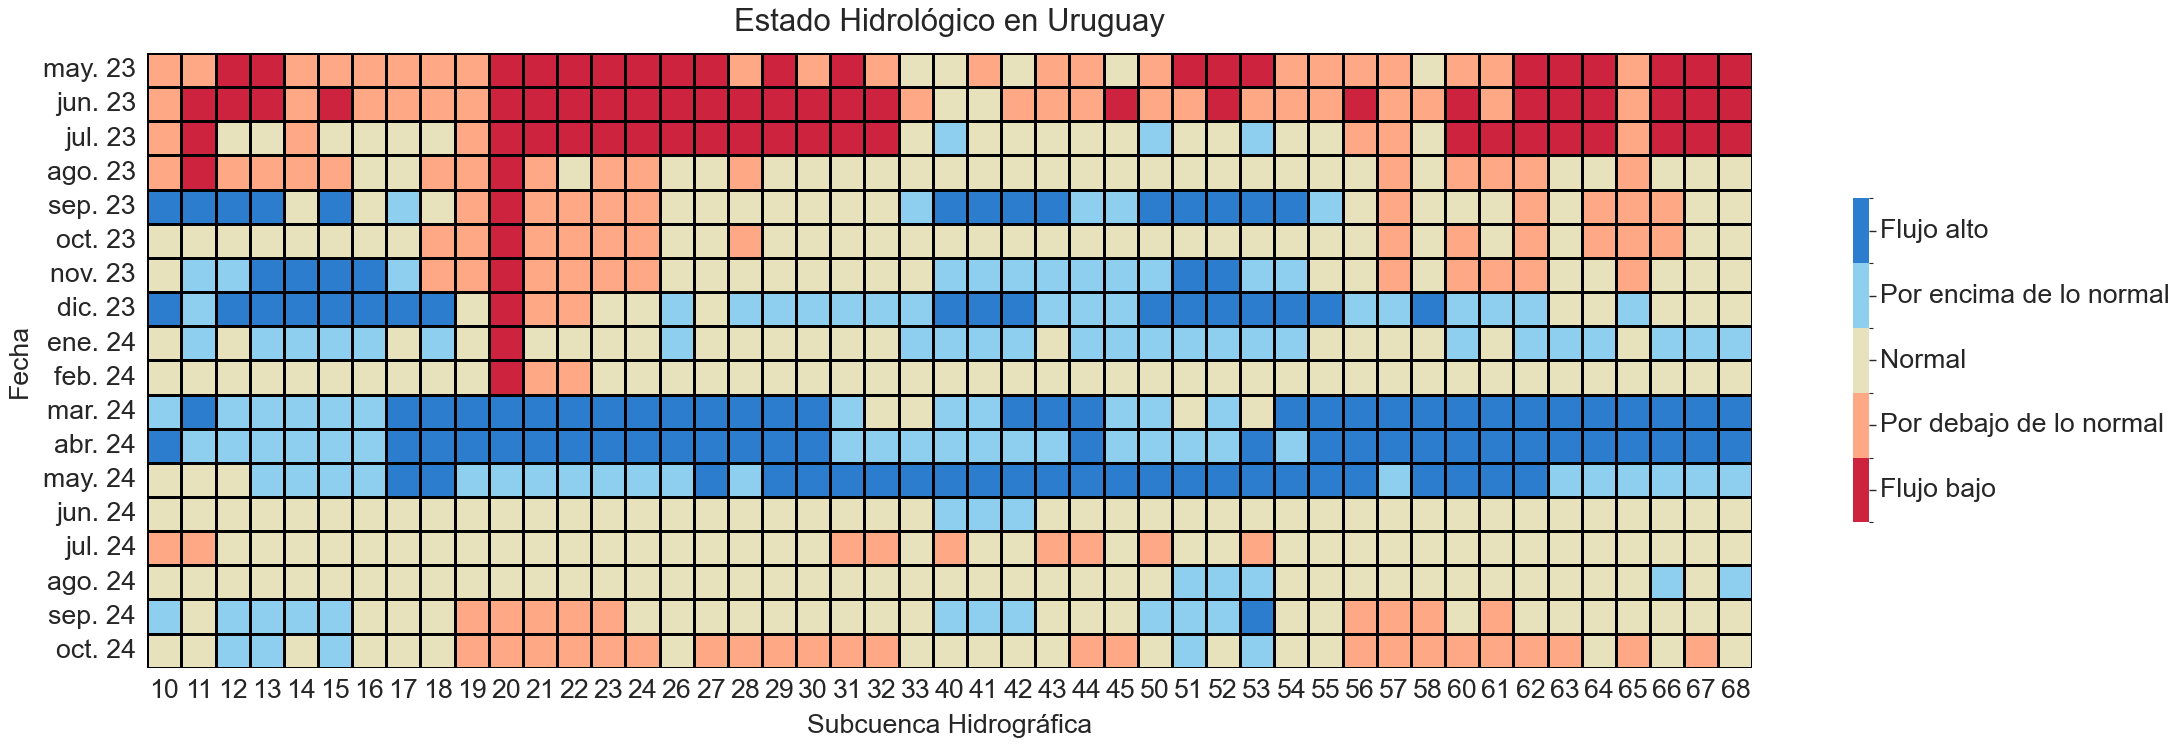

In [19]:
# Definir colores discretos para cada categoría
colors = ['#CD233F', '#FFA885', '#E7E2BC', '#8ECEEE', '#2C7DCD']
cmap = ListedColormap(colors)

bounds = [1, 2, 3, 4, 5, 6]
my_norm = BoundaryNorm(bounds, ncolors=len(colors))

font_size = 24

# Crear el heatmap
fig, ax = plt.subplots(figsize=(28,14))
ax = sns.heatmap(piv.T, 
                 square=True, 
                 cmap=cmap, 
                 vmin=1, 
                 vmax=5,
                 norm = my_norm,
                 annot=False, 
                 linewidths=1, 
                 linecolor='black', 
                 ax=ax,
                 cbar_kws={'label': '', 'orientation': 'vertical',"shrink":0.3})

ax.set_title('Estado Hidrológico en Uruguay', pad=20, loc='center', size=font_size + 4)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)

ax.set_xlabel('Subcuenca Hidrográfica', rotation=0, labelpad=10, fontsize=font_size)
ax.set_xticklabels(allbasins_n2.codcuenca, fontsize=font_size, rotation=0)

ax.set_ylabel('Fecha', rotation=90, labelpad=10, fontsize=font_size)
ax.set_yticklabels(df_cat_float['FECHA'].dt.strftime('%b %y'), fontsize=font_size)


colorbar = ax.collections[0].colorbar
colorbar.set_ticks([(b0+b1)/2 for b0, b1 in zip(bounds[:-1], bounds[1:])])
colorbar.set_ticklabels(['Flujo bajo', 'Por debajo de lo normal', 'Normal', 'Por encima de lo normal', 'Flujo alto'])

colorbar.ax.tick_params(labelsize=font_size)
colorbar.ax.yaxis.set_tick_params(rotation=0)
colorbar.ax.yaxis.set_label_position('left')
ax.figure.axes[-1].yaxis.label.set_size(font_size)

plt.rcParams.update({'font.family': 'Arial'})
plt.tight_layout()

plt.show()

